In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler


In [2]:
df = pd.read_csv('google_stock_data.csv')

In [3]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2010-01-04,15.689439,15.753504,15.621622,15.684434,15.684434,78169752
1,2010-01-05,15.695195,15.711712,15.554054,15.615365,15.615365,120067812
2,2010-01-06,15.662162,15.662162,15.174174,15.221722,15.221722,158988852
3,2010-01-07,15.250250,15.265265,14.831081,14.867367,14.867367,256315428
4,2010-01-08,14.814815,15.096346,14.742492,15.065566,15.065566,188783028


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3563 entries, 0 to 3562
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       3563 non-null   object 
 1   Open       3563 non-null   float64
 2   High       3563 non-null   float64
 3   Low        3563 non-null   float64
 4   Close      3563 non-null   float64
 5   Adj Close  3563 non-null   float64
 6   Volume     3563 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 195.0+ KB


In [5]:
# Use only the 'Close' column for prediction
df = df['Close'].values

In [6]:
scaler = MinMaxScaler()
df = scaler.fit_transform(df.reshape(-1, 1))

# In this case, when you reshape your array using reshape(-1, 1), 
# you're instructing NumPy to reshape the array into a 2D array with as many rows as needed and 1 column.
# The -1 indicates that NumPy should figure out the number of rows automatically based on the length of
# the original array and the fact that you want 1 column.

# So, if your original array has 100 elements, reshape(-1, 1) would reshape it into a 2D array with 100 rows and 1 column.

In [7]:
# Create sequences of 60 consecutive stock prices as features and the 61st price as the label
X = []
y = []
for i in range(60, len(df)):
    X.append(df[i-60:i, 0])
    y.append(df[i, 0])
X, y = np.array(X), np.array(y)

<!-- X = [] and y = []: Initialize empty lists to store the features and labels.
for i in range(60, len(df)):: Iterate over the range starting from index 60 (to ensure enough past data for the first sequence) up to the length of your data.
X.append(df[i-60:i, 0]): Append a sequence of 60 consecutive prices (from index i-60 to i-1) to the X list. df[i-60:i, 0] slices the DataFrame to select rows from i-60 to i-1 and the first (0th) column.
y.append(df[i, 0]): Append the 61st price (at index i) to the y list.
X, y = np.array(X), np.array(y): Convert the lists X and y into NumPy arrays, which are more efficient for numerical computations.
This approach effectively creates input-output pairs for training a model where each input (X) is a sequence of 60 prices and the corresponding output (y) is the next price after that sequence. -->

In [8]:
# Reshape X to be of shape (samples, time steps, features) which is required for LSTM
X = np.reshape(X, (X.shape[0], X.shape[1], 1))

In [ ]:
# X.shape[0]: This represents the number of samples in your dataset. Each sample is a sequence of 60 consecutive stock prices.
# X.shape[1]: This represents the number of time steps in each sequence, which is 60 in your case.
# 1: This represents the number of features at each time step. Since you're using only the 'Close' price as the feature, you have one feature per time step.
# By reshaping X to (X.shape[0], X.shape[1], 1), you're essentially adding a third dimension to your data. This reshaping is necessary because many deep learning frameworks, including TensorFlow and PyTorch, expect input data for RNNs to be in the shape of (batch_size, sequence_length, num_features).

# So, X.shape[0] indicates the number of samples (or sequences), X.shape[1] indicates the length of each sequence, and the added 1 indicates the number of features at each time step.

In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, SimpleRNN

In [10]:
# Tanh (hyperbolic tangent) activation function is commonly used in RNN architectures, 
# including SimpleRNN layers, because it allows the network to capture both positive and negative activations.
# This is important for capturing a wide range of patterns and features in sequential data.
# Tanh activation function outputs values in the range (-1, 1), making it suitable for RNNs where the input and output
# values are often normalized within this range.
# While ReLU (Rectified Linear Unit) activation function is commonly used in feedforward neural networks (DNNs)
# due to its simplicity and computational efficiency, it may not be as suitable for RNNs because it doesn't 
# handle negative values well and can lead to vanishing gradients in long sequences.
# Sigmoid activation function could also be used in RNNs, but tanh is often preferred because it offers a
# wider range of values and helps alleviate the vanishing gradient problem better than sigmoid.


model = Sequential()

model.add(SimpleRNN(units=50,activation = "tanh", return_sequences = True, input_shape = (X.shape[1], 1)))
model.add(Dropout(0.2))

model.add(SimpleRNN(units=50,activation = "tanh", return_sequences = True))
model.add(Dropout(0.2))

model.add(SimpleRNN(units=50,activation = "tanh", return_sequences = True))
model.add(Dropout(0.2))

model.add(SimpleRNN(units=50))
model.add(Dropout(0.2))

model.add(Dense(units=1))

model.compile(optimizer='adam',loss='mse')
model.summary()

# Therefore, there are a total of 5 layers in the model: 4 SimpleRNN layers and 1 Dense layer.

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 60, 50)            2600      
                                                                 
 dropout (Dropout)           (None, 60, 50)            0         
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 60, 50)            5050      
                                                                 
 dropout_1 (Dropout)         (None, 60, 50)            0         
                                                                 
 simple_rnn_2 (SimpleRNN)    (None, 60, 50)            5050      
                                                                 
 dropout_2 (Dropout)         (None, 60, 50)            0         
                                                                 
 simple_rnn_3 (SimpleRNN)    (None, 50)                5

In [ ]:
# return_sequences=True: This parameter specifies whether the SimpleRNN layer should return the full sequence of outputs for each input sequence. When return_sequences=True, the layer will output a sequence of outputs for each time step in the input sequence. This is useful when stacking multiple recurrent layers or when you need to predict a sequence rather than a single value.
# input_shape=(X.shape[1], 1): This parameter specifies the shape of the input data that the SimpleRNN layer expects. It is a tuple (time_steps, num_features) where:
# time_steps corresponds to the number of time steps in each input sequence. In this context, X.shape[1] represents the length of each sequence, which is 60 in your case.
# num_features corresponds to the number of features at each time step. Since you're using only the 'Close' price as the feature, you have one feature per time step, hence 1.
# So, (X.shape[1], 1) specifies that each input sequence has 60 time steps (each representing a stock price) and each time step has one feature (the 'Close' price). This shape is compatible with the shape of your input data X.

In [11]:
# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X,y,epochs=10,batch_size=30,validation_split=0.05)

Epoch 1/10
111/111 [==============================] - 10s 66ms/step - loss: 0.3031 - val_loss: 0.0263
Epoch 2/10
111/111 [==============================] - 7s 64ms/step - loss: 0.1210 - val_loss: 0.0315
Epoch 3/10
111/111 [==============================] - 8s 68ms/step - loss: 0.0551 - val_loss: 0.0042
Epoch 4/10
111/111 [==============================] - 7s 62ms/step - loss: 0.0327 - val_loss: 0.0161
Epoch 5/10
111/111 [==============================] - 7s 66ms/step - loss: 0.0212 - val_loss: 0.0164
Epoch 6/10
111/111 [==============================] - 7s 63ms/step - loss: 0.0154 - val_loss: 0.0169
Epoch 7/10
111/111 [==============================] - 7s 60ms/step - loss: 0.0127 - val_loss: 0.0335
Epoch 8/10
111/111 [==============================] - 7s 64ms/step - loss: 0.0122 - val_loss: 0.0158
Epoch 9/10
111/111 [==============================] - 7s 66ms/step - loss: 0.0080 - val_loss: 0.0028
Epoch 10/10
111/111 [==============================] - 8s 72ms/step - loss: 0.0080 - val_l

In [ ]:
# batch_size: The number of samples per gradient update. This determines how many samples are processed before the model's parameters are updated.
# validation_split: The fraction of the training data to use as validation data. In this case, 5% of the training data will be used for validation during training.

110/110 [==============================] - 2s 15ms/step


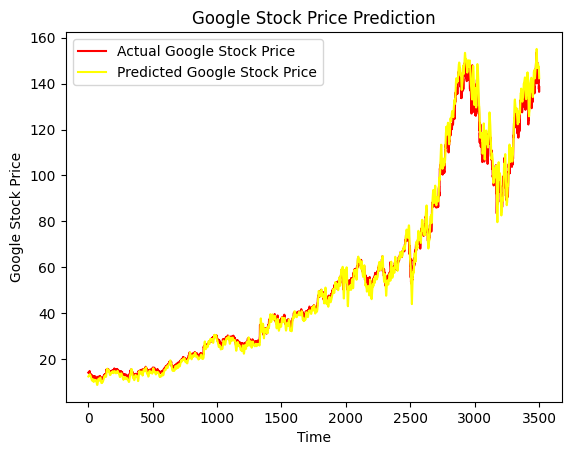

In [12]:
import matplotlib.pyplot as plt

# Generate predictions
predicted_prices = model.predict(X)
predicted_prices = scaler.inverse_transform(predicted_prices)  # Undo scaling

# Get the actual prices (also undo scaling)
actual_prices = scaler.inverse_transform(y.reshape(-1, 1))

# Plot the actual vs predicted prices
plt.plot(actual_prices, color='red', label='Actual Google Stock Price')
plt.plot(predicted_prices, color='yellow', label='Predicted Google Stock Price')
plt.title('Google Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Google Stock Price')
plt.legend()
plt.show()

#110/110 means it has made 110 predictions out of 110 samples

In [ ]:
# predicted_prices = model.predict(X): This line generates predictions using the trained model. It uses the input data X to generate predictions for the corresponding target data y.
# predicted_prices = scaler.inverse_transform(predicted_prices): After generating predictions, this line reverses the scaling transformation applied earlier using MinMaxScaler. It transforms the predicted prices back to their original scale.
# actual_prices = scaler.inverse_transform(y.reshape(-1, 1)): Similarly, this line transforms the actual prices back to their original scale.
# Plotting: The next few lines of code use matplotlib to create a plot showing the actual (red) and predicted (yellow) prices over time.

In [13]:
from sklearn.metrics import r2_score

r2 = r2_score(actual_prices, predicted_prices)

# print the R-squared value as a percentage
print("R-squared: {:.2f}%".format(r2 * 100))

R-squared: 99.40%



The R-squared (R2) score, also known as the coefficient of determination, is a statistical measure that indicates the proportion of the variance in the dependent variable (the target) that is predictable from the independent variables (the features) in a regression model.

In the context of regression analysis, such as predicting stock prices, the R-squared score measures how well the regression model explains the variability of the target variable around its mean. It is a measure of how well the predictions from the model match the observed data.

The R-squared score ranges from 0 to 1:

An R-squared score of 0 indicates that the regression model does not explain any of the variability in the target variable. Essentially, the model provides no predictive power.
An R-squared score of 1 indicates that the regression model perfectly explains all the variability in the target variable. The model's predictions match the observed data perfectly.
However, it's important to note that R-squared alone does not indicate whether a model is good or bad. Even a model with a high R-squared value may not be a good model if it suffers from issues like overfitting or underfitting. Therefore, it's essential to consider other metrics and perform additional evaluations to assess the overall performance of the model.

SimpleRNN stands for Simple Recurrent Neural Network, which is a type of recurrent neural network (RNN) architecture.
It is the simplest form of RNN, where each neuron in the network receives input not only from the current time step but also from the output of the previous time step.
SimpleRNN has a simple architecture, but it suffers from the vanishing gradient problem, which limits its ability to capture long-range dependencies in sequences.
Despite its limitations, SimpleRNN can still be useful for certain tasks and serves as a foundational building block for more complex RNN architectures like LSTM (Long Short-Term Memory) and GRU (Gated Recurrent Unit).

# vanishing gradient- relu removes vanishing gradient

In neural networks, training involves adjusting the weights of connections between neurons based on feedback (gradients) received during training. The vanishing gradient problem occurs when these gradients become extremely small as they propagate backward through the network during training. It's like the feedback you're giving to the students becomes so weak or unclear that they stop learning effectively.
When gradients become too small, the network's weights stop updating properly, and learning slows down or stops altogether. This typically happens in deep neural networks with many layers, especially when using activation functions like sigmoid or tanh, which have flat regions where gradients approach zero.